In [19]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)


In [20]:
start = time.time()

home = os.path.expanduser("~")

direc = os.listdir(".")


In [21]:
def empty(df):
    return len(df.index) == 0
    
def fwhm(valuelist, peakpos,base):
    peakvalue = valuelist[peakpos]-base
    phalf = (peakvalue / 2.0)+base

    # go left and right, starting from peakpos
    ind1 = peakpos
    ind2 = peakpos   

    while ind1>2 and valuelist[ind1]>phalf:
        ind1=ind1-1
    while ind2<len(valuelist)-1 and valuelist[ind2]>phalf:
        ind2=ind2+1  
    return ind1,ind2

def tE_finder (t,f,f_s):
    df = pd.DataFrame({'t' : t, 'f' : f})
    
    A_base = (float(f_s)*0.34)+1
    
    t_max = df['t'][df['f'].argmax()]
    t_right = df['t'][df['t']>t_max]
    t_left = df['t'][df['t']<t_max]
    
    if empty(t_right) == 'False':
        tE_right = np.abs(t_right[(np.abs(df['f'][df['t']>t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_right = 1
    if empty(t_left) == 'False':
        tE_left = np.abs(t_left[(np.abs(df['f'][df['t']<t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_left = 1
    
    return min([tE_right,tE_left])

def fun (t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return (f_s * (A-1)) +1
        
def fun2 (mean, sigma,amp, t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((df['t']-mean)**2)/(2*(sigma**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    return (f_s * (A-1)) +1

def lnlike(theta, t, f, f_err):
    t0, u0, tE,f_s = theta
    model = fun(t0, u0, tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def lnlike2(theta, t, f, f_err):
    mean, sigma,amp, t0,u0,tE,f_s = theta
    model = fun2(mean, sigma,amp, t0,u0,tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [75]:
name = 'cassan_12_76_1629.det.lc.gz'  
tempdata = home+'/Library/Mobile Documents/com~apple~CloudDocs/project_microlensing/shared_lc/'+str(name) #'/Desktop/alllc1/'+str(name) #

t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
df = pd.DataFrame({'t':t , 'f':f , 'f_err' : f_err , 'f_true': f_true, 'code':code})
df = df[df['code']==4]
df = df.reset_index(drop=True)

#df['f'] = df['f_true']

fname = gzip.open(tempdata, 'rb')
x_0 = fname.readlines()[0:7]
f_s_true = x_0[0].split(' ')[4]
q = x_0[5].split(' ')[5]
s = x_0[5].split(' ')[6]
tE_theo = x_0[6].split(' ')[4]
t0_theo = x_0[6].split(' ')[3]
u0_theo = x_0[6].split(' ')[1]


In [69]:
max_f = max(df['f'])
max_t = df['t'][df['f'].argmax()]
range_one_day = df[(df['t']>max_t-1) & (df['t']<max_t+1)]
argmax = df['f'].argmax()
# if len(range_one_day[range_one_day['f']>1.3])<5:
#     max_f = max(df['f'][(df['t']<max_t-1) | (df['t']>max_t+1)])
#     max_t = df['t'][(df['f'][(df['t']<max_t-1) | (df['t']>max_t+1)]).argmax()]
#     argmax = (df['f'][(df['t']<max_t-1) | (df['t']>max_t+1)]).argmax()

In [70]:
#u0_true = float(f_s_true)/(max(df['f'])-1+float(f_s_true))
A_max = 1.0/(float(f_s_true)/(max_f-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  max_t #df['t'][df['f'].argmax()] #float(t0_theo)
ind1, ind2 = fwhm(df['f'],argmax,min(df['f']))
#tE_true = t[ind2]-t[ind1]
tE_true = [tE_finder (df['t'],df[ 'f'], f_s_true),t[ind2]-t[ind1]]
#print 'tE_true = '+ str( tE_true)


In [71]:
tE_true

[1, 846.49719909]

In [72]:
tE_ = [[],[]]    
for i in tE_true:
               
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [t0_true, u0_true, i,f_s_true], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    tE_[0].append(lnlike([t0_ml, u0_ml, tE_ml,f_s_ml],df['t'],df[ 'f'], df['f_err']))
    tE_[1].append([t0_ml, u0_ml, tE_ml,f_s_ml])

In [73]:
#print tE_[1]
mm = np.asarray( tE_[0])
tE__ = tE_[1][mm.argmax()]

t0_ml, u0_ml, tE_ml,f_s_ml = tE__[0],tE__[1],tE__[2],tE__[3]

f_ris = df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)
f_ris_true = df['f_true']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)


# #u0_true = float(f_s_true)/(max(df['f']-f_ris)-1+float(f_s_true))
A_max = 1.0/(float(f_s_true)/(max(df['f']-f_ris)-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true = df['t'][(df['f']-f_ris).argmax()]

# A_max = 1.0/(float(f_s_true)/(max(smooth(df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml),19))-1+float(f_s_true)))
# u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
# t0_true = df['t'][(smooth(df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml),19)).argmax()]

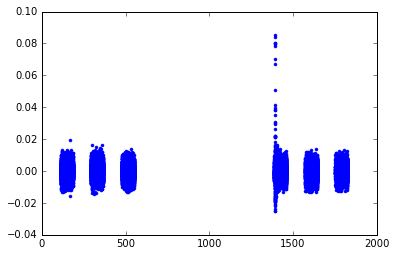

In [74]:
plt.plot(df['t'],f_ris,'b.')
f_ris.to_csv('example_residual_multi_peak_5.dat',header='None',index='None')

In [39]:
#print 't0_true = ' + str(t0_true)
        

duration = [0.01,0.1,1]  

cut = 100
    
# f_ris__ = [(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).max(),(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).min()]
# t_ris__ =  [df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmax()], df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmin()]] 

f_ris = smooth(f_ris,19)
f_ris_true = smooth(f_ris_true,19)

if u0_ml>0.7:
        f_ris = smooth(f_ris,19)
        f_ris_true = smooth(f_ris_true,19)

f_ris__ = [f_ris.max(),f_ris.min()]
t_ris__ = [df['t'][f_ris.argmax()],df['t'][f_ris.argmin()]]


In [40]:
min_model_ = [[],[]]

for sigma in duration:
            
    for a in range(0,2):        
        amp_ = f_ris__[a]
        #print amp_
        t_mean_ = t_ris__[a]
        
        
        amp_ = amp_ * sigma * np.sqrt(2*np.pi)
        #print 'sigma = '+str(sigma) + ', amp = '+ str(amp_)
    
        nll = lambda *args: -lnlike2(*args)
        result = op.minimize(nll, [t_mean_,sigma,amp_,t0_ml, u0_ml, tE_ml,f_s_ml], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
        mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll = result['x']
        #print result['x']
        min_model_[0].append(lnlike2([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll],df['t'],df[ 'f'], df['f_err']))
        min_model_[1].append([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll])


In [41]:
mmm_ = np.asarray( min_model_[0])
final_param = min_model_[1][mmm_.argmax()]       

'''
mmm_ = np.abs(np.asarray( min_model_[0])-mm.max())
if max(mmm_)>200:
    final_param = min_model_[1][mmm_.argmax()]
else:
    final_param = min_model_[1][mmm_.argmin()]    
'''    
    
#print 'second fit =' + str(final_param)
  

'\nmmm_ = np.abs(np.asarray( min_model_[0])-mm.max())\nif max(mmm_)>200:\n    final_param = min_model_[1][mmm_.argmax()]\nelse:\n    final_param = min_model_[1][mmm_.argmin()]    \n'

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:94: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


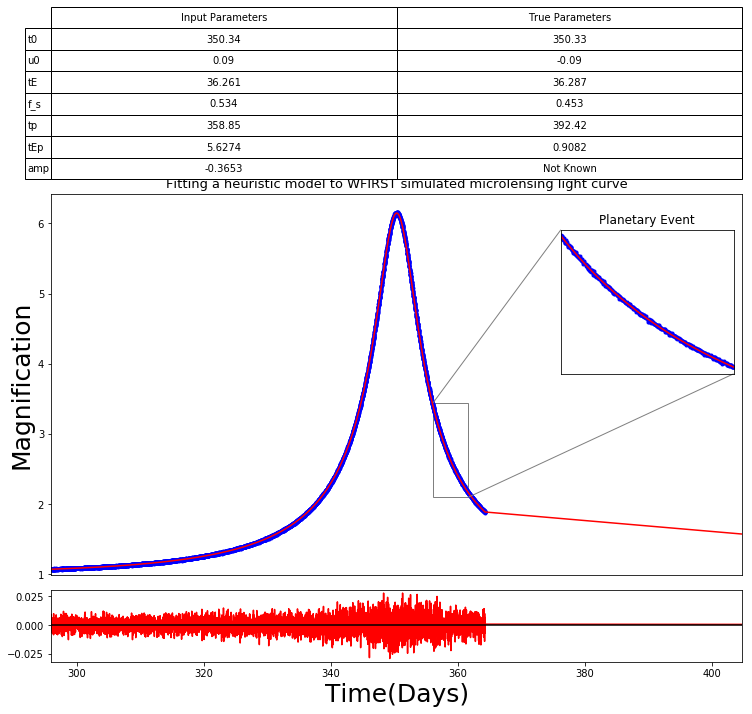

In [42]:
x_c = np.sqrt((final_param[4]**2)+((final_param[3]-final_param[0])/final_param[5])**2 )

if final_param[2] >0:
    s_exp = (x_c+np.sqrt((x_c**2)+4))/2   
elif final_param[2] <0:
    s_exp = np.abs((x_c-np.sqrt((x_c**2)+4))/2)
#print 'theo q = ' +q +',theo s = ' +s
#print 'exp q = '+str((final_param[1]/final_param[5])**2)+ ', exp s = ' +str(s_exp)
    
# theoretical values of mass ratio
#q_[1].append(np.log10(float(q)))
# experimental values of mass ratio
#q_[0].append(np.log10((final_param[1]/final_param[5])**2))
# theoretical values of separation
#s_[1].append(np.log10(float(s)))
# experimental values of separation
#q_[0].append(np.log10(s_exp))

del_t = round((np.sqrt(np.abs((float(s)-(1/float(s)))**2 - (float(u0_theo))**2))),2) * float(tE_theo)

right = str(round(float(t0_theo)+del_t,2))
left = str(round(float(t0_theo)-del_t,2))

cell_text = [[round(final_param[3],2),round(float(t0_theo),2)],[round(final_param[4],2),round(float(u0_theo),2)],[round(final_param[5],3),round(float(tE_theo),3)],
             [round(final_param[6],3),round(float(f_s_true),3)],[round(final_param[0],2),right],
            [round(np.abs(final_param[1]),4),round(np.sqrt(float(q))*float(tE_theo),4)],[round(final_param[2],4),'Not Known']]
        
rows = ('t0','u0','tE','f_s','tp','tEp','amp')   
columns = ('Input Parameters','True Parameters')

           
f_res_final = df['f']-fun2(final_param[0],final_param[1],final_param[2],final_param[3],final_param[4],final_param[5],final_param[6])                        
                                 
# definitions for the axes
left, width = 0.1, 0.8
bottom, height_1,height_2, height_3 = 0.07,0.1, 0.53 ,0.2
bottom_2 = bottom+ height_1 +0.02
bottom_3 = bottom_2 + height_2+0.04

rect_1 = [left, bottom, width, height_1]
rect_2 = [left, bottom_2, width, height_2]
rect_3 = [left, bottom_3, width, height_3]                                            
                                                       
plt.close()
plt.figure(1, figsize=(15,12)) 
                                                          
residual = plt.axes(rect_1)
main = plt.axes(rect_2)
tbl = plt.axes(rect_3)                                                                            

tp_range = array([float(t0_theo)-del_t,float(t0_theo)+del_t])

tp_theo = tp_range[np.abs(tp_range-final_param[0]).argmin()]

range_p = [final_param[0]-((np.sqrt(float(q))*float(tE_theo))*3),     
          final_param[0]+((np.sqrt(float(q))*float(tE_theo))*3)]

if len(df['f'][(df['t']>range_p[0]) & (df['t']<range_p[1])]) == 0:
    range_p = [float(tp_theo)-((np.sqrt(float(q))*float(tE_theo))*3),     
               float(tp_theo)+((np.sqrt(float(q))*float(tE_theo))*3)]
               
f_range_p = df['f'][(df['t']>range_p[0]) & (df['t']<range_p[1])]
t_range_p = df['t'][(df['t']>range_p[0]) & (df['t']<range_p[1])]


khengool = float(tE_theo)*1.5
if del_t> np.abs(final_param[0]-float(t0_theo)):
    while (del_t> khengool ):
        khengool = khengool + 0.1 * khengool
elif del_t< np.abs(final_param[0]-float(t0_theo)):
    while (np.abs(final_param[0]-float(t0_theo)) > khengool ):
        khengool = khengool + 0.1 * khengool
                
main_t_range =  [ float(t0_theo)-khengool,float(t0_theo)+khengool]     
    
if not len(t_range_p)==0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                                
    tbl.axis('tight')
    tbl.axis('off')
    the_table = tbl.table(cellText=cell_text,rowLabels=rows,colLabels=columns,loc='center',cellLoc='center')
    prop = the_table.properties()
    cells = prop['child_artists']
    for cell in cells:
        cell.set_height(0.15)
    #main.set_title('Simulated WFIRST lc plus the functional modeling for '+'"'+str(name)+'"')
    main.set_title('Fitting a heuristic model to WFIRST simulated microlensing light curve', size=13)
    main.plot(df['t'],df['f'],'b.',df['t'],fun2(final_param[0],final_param[1],final_param[2],final_param[3],final_param[4],final_param[5],final_param[6]),'r')#plt.text(485,25, str(info), style='italic',bbox={'facecolor':'none','alpha':0.5, 'pad':10})
    main.axis([main_t_range[0],main_t_range[1],min(df['f']),max(df['f'])+(0.05*(max(df['f'])-min(df['f'])))])
    main.axes.get_xaxis().set_ticks([])
    main.set_ylabel('Magnification',size=25)
    #main.text(main_t_range[0]+2, max(df['f'])-0.005, 'Fail', style='italic',size=20,
    #        bbox={'facecolor':'red', 'alpha':0.3, 'pad':10})
    if df['t'][df['f'].argmax()] >856 :
        inset = plt.axes([left+0.01, bottom_3-0.04-0.2-0.05, 0.2, 0.2])
    else:
        inset = plt.axes([0.9-0.2-0.01, bottom_3-0.04-0.2-0.05, 0.2, 0.2])
    #ip = InsetPosition(main, [0.4, 0.1, 0.3, 0.7]) #posx, posy, width, height
    #inset.set_axes_locator(ip)
    inset.set_title('Planetary Event')
    inset.plot(df['t'],df['f'],'b.',df['t'],fun2(final_param[0],final_param[1],final_param[2],final_param[3],final_param[4],final_param[5],final_param[6]),'r')
    x1, x2, y1, y2 = min(t_range_p)-0.05,max(t_range_p)+0.05,min(f_range_p),max(f_range_p)
    inset.set_xlim(x1, x2)
    inset.set_ylim(y1-(0.05*(y2-y1)), y2+(0.05*(y2-y1)))
    inset.axes.get_xaxis().set_ticks([])
    inset.axes.get_yaxis().set_ticks([])

    mark_inset(main, inset, loc1=2, loc2=4, fc="none", ec="0.5")
    residual.plot(df['t'],f_res_final,'r-',markersize=3)
    residual.axhline(y=0,color='black')
    residual.axis([main_t_range[0],main_t_range[1],min(f_res_final)-(0.05*(max(f_res_final)-min(f_res_final))),max(f_res_final)+(0.05*(max(f_res_final)-min(f_res_final)))])
    residual.set_xlabel('Time(Days)',size=25)
    fig = plt.gcf()
    fig.set_size_inches(12.0,10.0)
    #fig.savefig(home+'/Desktop/'+str(name)+'_lc.png')


    plt.show()

(340, 360)

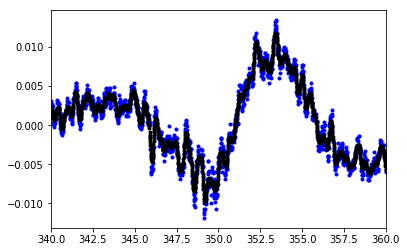

In [44]:
plt.plot(df['t'],f_ris,'b.')
plt.plot(df['t'],smooth(f_ris,19),'k.')
#plt.plot(df['t'],df['f']/fun(t0_ml, u0_ml, tE_ml,f_s_ml),'k.')
#plt.plot(df['t'],smooth(df['f']/fun(t0_ml, u0_ml, tE_ml,f_s_ml),19),'r.')



fun(t0_ml, u0_ml, tE_ml,f_s_ml)

#df['t'][smooth(f_ris,19).argmin()]
plt.xlim(340,360)

In [43]:
min(f_ris)
df['t'][f_ris.argmax()]

353.45099537

In [15]:
max(f_ris)

0.0730326861440378